In [1]:
import numpy as np
from neoradium import AntennaElement,AntennaPanel, CsiReport
from neoradium import Carrier, PDSCH, Grid, CsiRsConfig, CsiRsSet, CdlChannel

In [2]:
carrier = Carrier(startRb=0, numRbs=52, spacing=15)
bwp = carrier.bwps[0]
bwp.print()
bwp.symbolLens.sum()


Bandwidth Part Properties:
  Resource Blocks: 52 RBs starting at 0 (624 subcarriers)
  Subcarrier Spacing: 15 KHz
  CP Type: normal
  bandwidth: 9360000 Hz
  symbolsPerSlot: 14
  slotsPerSubFrame: 1
  nFFT: 1024



16384

In [3]:
# Create 3 NZP CsiRsSet objects in the CsiRsConfig. All of them are NZP, transmitted on first symbol
# of the slot (Symbol 0), use 4 ports, and occupy REs (0,1,2,3), (4,5,6,7), and (8,9,10,11) correspondingly.
csiRsConfig = CsiRsConfig([CsiRsSet("NZP", bwp, symbols=[0], freqMap=fm, numPorts=4) for fm in 
                               ["001", "010", "100"]])  # Different freq. maps for each CsiRsSet
# csiRsConfig.print()

# Create a grid and put CSI-RS info inside the grid: 
grid = bwp.createGrid(csiRsConfig.numPorts)
csiRsConfig.populateGrid(grid)

# Grid Stats:
print("Grid Stats:")
stats = grid.getStats()
for key, value in stats.items(): print("  %s: %d"%(key, value))
    
# Visualize the grid:
# grid.drawMap(ports=range(csiRsConfig.numPorts), reRange=(0,36))

Grid Stats:
  GridSize: 34944
  UNASSIGNED: 33696
  CSIRS_NZP: 1248


(array([1, 2], dtype=int16), 4)

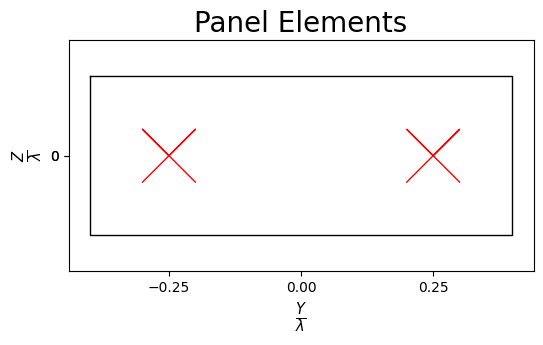

In [4]:
# Create an antenna panel using default antenna element template.
txAntenna = AntennaPanel([1,2], polarization="x")
txAntenna.showElements(zeroTicks=True)
txAntenna.shape, txAntenna.getNumElements()

In [5]:
# Create a CDL-C channel model with 300ns delay spread, 4GHz carrier frequency, and 5Hz doppler shift
channel = CdlChannel('D', delaySpread=10, carrierFreq=4e9, dopplerShift=10,
                     txAntenna = txAntenna,
                     rxAntenna = AntennaPanel([1,2], polarization="+"),       # 4 RX antenna
                     timing="linear") # Nearest Neighbors interpolation (Also try: "Polar", "linear")
print(channel)


CDL-D Channel Properties:
  delaySpread: 10 ns
  dopplerShift: 10 Hz
  carrierFreq: 4000000000.0 Hz
  normalizeGains: True
  normalizeOutput: True
  txDir: Downlink
  timing method: linear
  coherenceTime: 0.042314 (Sec.)
  ueDirAZ: 0°, 90°
  pathDelays (ns): 0.0000 0.0000 0.3500 6.1200 13.630 14.050 18.040 25.960 17.750 40.420
                   79.370 94.240 97.080 125.25
  pathPowers (db): -0.200 -13.50 -18.80 -21.00 -22.80 -17.90 -20.10 -21.90 -22.90 -27.80
                   -23.60 -24.80 -30.00 -27.70
  AODs (Degree):    0    0   89   89   89   13   13   13   35  -64  -33   53 -132   77
  AOAs (Degree): -180 -180   89   89   89  163  163  163 -137   74  128 -120   -9  -84
  ZODs (Degree):   98   98   86   86   86   98   98   98   98   88   91  104   80   86
  ZOAs (Degree):   82   82   87   87   87   79   79   79   78   74   78   87   71   73
  hasLOS: True
  Cross Pol. Power: 11 db
  angleSpreads: 5° 8° 3° 3°
  TX Antenna:
    Total Elements: 4
    spacing: 0.5𝜆, 0.5𝜆
    shape

In [6]:
hActual = channel.getChannelMatrix(bwp, numSlots=1, timeDomain=True)


In [7]:
waveForm = grid.ofdmModulate()
print("Waveform Shape:", waveForm.shape)


Waveform Shape: (4, 16384)


In [8]:
maxDelay = channel.getMaxDelay()
print("Max. Channel Delay (Samples):",maxDelay)
# Append to the waveForm before passing it through the channel
txWaveform = waveForm.pad(maxDelay)
print("txWaveform Shape:", txWaveform.shape)

# Now apply the channel to the waveform
rxWaveform = channel.applyToSignal(txWaveform)
print("rxWaveform Shape:", txWaveform.shape)

# Add noise: (SNR=10 dB)
noisyWaveForm = rxWaveform.addNoise(snrDb=50, nFFT=bwp.nFFT)
noisyWaveForm.shape

Max. Channel Delay (Samples): 11
txWaveform Shape: (4, 16395)
rxWaveform Shape: (4, 16395)


(4, 16395)

In [9]:
# We can get channel delay from the channel (This is cheating because we don't know the channel)
chOffset = channel.getTimingOffset(txWaveform.shape[1])
print("Channel Offset from the Channel Model:", chOffset)

# Or estimate the offset using a resource grid with NZP CSI-RS and the recived signal
# Only use NZP resources:
rxCsiRsConfig = CsiRsConfig([csiRsSet for csiRsSet in csiRsConfig.csiRsSetList if csiRsSet.csiType=="NZP"])

csiRsGrid = bwp.createGrid(rxCsiRsConfig.numPorts)
rxCsiRsConfig.populateGrid(csiRsGrid)
offset = csiRsGrid.estimateTimingOffset(noisyWaveForm)
print("Estimated Offset:", offset)

Channel Offset from the Channel Model: 7
Estimated Offset: 7


In [10]:
# Now apply the offset to the received waveform
syncedWaveForm = noisyWaveForm.sync(offset)
print("syncedWaveForm Shape:", syncedWaveForm.shape)


syncedWaveForm Shape: (4, 16388)


In [11]:
rxGrid = Grid.ofdmDemodulate(bwp, syncedWaveForm)
rxGrid.shape

(4, 14, 624)

In [12]:
# Least Squares Channel Estimation
hEst, _ = rxGrid.estimateChannelLS(rxCsiRsConfig,kernel="linear") 
hEst.shape, hActual.shape


((14, 624, 4, 4), (14, 624, 4, 4))

In [13]:
print("Min Absolute Error:", np.abs(hActual-hEst).min())
print("Max Absolute Error:", np.abs(hActual-hEst).max())
print("Mean Absolute Error:", np.abs(hActual-hEst).mean())
print("MSE:", np.square(np.abs(hActual-hEst)).mean())

# Print symbol values for the first subcarrier for the first pair of antennas
print("Actual Channel:\n", hActual[:,0,0,0])
print("Estimated Channel:\n", hEst[:,0,0,0])


Min Absolute Error: 4.152077454384459e-06
Max Absolute Error: 0.004140206755751211
Mean Absolute Error: 0.0012053535933496415
MSE: 1.8658583014719393e-06
Actual Channel:
 [0.06177877-0.00491705j 0.06175917-0.00506486j 0.06173923-0.00521265j
 0.06171894-0.0053604j  0.0616983 -0.00550813j 0.06167732-0.00565583j
 0.061656  -0.00580349j 0.06163403-0.00595314j 0.06161201-0.00610074j
 0.06158965-0.00624831j 0.06156694-0.00639584j 0.06154389-0.00654333j
 0.06152049-0.00669079j 0.06149675-0.00683821j]
Estimated Channel:
 [0.06072263-0.00625106j 0.06072263-0.00625106j 0.06072263-0.00625106j
 0.06072263-0.00625106j 0.06072263-0.00625106j 0.06072263-0.00625106j
 0.06072263-0.00625106j 0.06072263-0.00625106j 0.06072263-0.00625106j
 0.06072263-0.00625106j 0.06072263-0.00625106j 0.06072263-0.00625106j
 0.06072263-0.00625106j 0.06072263-0.00625106j]


In [14]:
idxes = grid.getReIndexes("CSIRS_NZP")
p1Idxes = np.where(idxes[0]==0)[0]
idxes = (idxes[0][p1Idxes], idxes[1][p1Idxes], idxes[2][p1Idxes]) # indexes in 1st port
idxes


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [15]:
csiReport = CsiReport(bwp=bwp, csiRsConfig=rxCsiRsConfig, codebookType="Type1SP", 
                      codebookMode=1, txAntenna=txAntenna)

In [18]:
self = csiReport

def removeNeighbors(idx):
    # idx is the 2D indexes (port removed). It is a tuple (x, y).
    # We have a CSI-RS RE at symbol x[i], and subcarrier y[i].
    # We want to use only one RE for a set of Neighboring REs (i.e. the ones in the same CDM group)
    bmp = np.ones((idx[0].max()+3,idx[1].max()+3),dtype=np.int8)*2
    bmp[(idx[0]+1,idx[1]+1)] = 1
    x,y = np.where(bmp[:,1:]-bmp[:,:-1]!=-1)
    bmp[ (x,y+1) ] = 2
    x,y = np.where(bmp[1:,:]-bmp[:-1,:]!=-1)
    bmp[ (x+1,y) ] = 2
    x,y = np.where(bmp==1)
    return (x-1,y-1)

csiRsGrid = self.bwp.createGrid(self.numPorts)
self.csiRsConfig.populateGrid(csiRsGrid)
csiRsIndexes = grid.getReIndexes("CSIRS_NZP")   # A tuple of (ports, symbols, subcarriers)
p0Idx = np.where(csiRsIndexes[0]==0)[0]         # Indexes in the csiRsIndexes corresponding to port 0
csiRsIndexesP0 = (idxes[1][p1Idxes], idxes[2][p1Idxes])     # A tuple of (symbols, subcarriers) corresponding to port 0
csiRsIndexesP0

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
csiRsIndexesP0 = removeNeighbors(csiRsIndexesP0)
csiRsIndexesP0

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]),
 array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
         52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
        104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152,
        156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204,
        208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256,
        260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308,
        312, 316, 320, 324, 

In [24]:
hAtCsiRs = hActual[csiRsIndexesP0]
hAtCsiRs.shape

(156, 4, 4)

In [25]:
csiRsIndexesP0

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]),
 array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
         52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
        104, 108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152,
        156, 160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204,
        208, 212, 216, 220, 224, 228, 232, 236, 240, 244, 248, 252, 256,
        260, 264, 268, 272, 276, 280, 284, 288, 292, 296, 300, 304, 308,
        312, 316, 320, 324, 

In [37]:
idx = np.where((csiRsIndexesP0[1]<96)&(csiRsIndexesP0[1]>48))[0]
idx

array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

In [38]:
(csiRsIndexesP0[0][idx], csiRsIndexesP0[1][idx])

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92]))

In [17]:
indexes, codebook = csiReport.getCodebook(numLayers=1)
codebook.shape, len(indexes)

((64, 4, 1), 64)

In [18]:
indexes

[[[0, 0], 0],
 [[0, 0], 1],
 [[0, 0], 2],
 [[0, 0], 3],
 [[0, 0], 4],
 [[0, 0], 5],
 [[0, 0], 6],
 [[0, 0], 7],
 [[0, 0], 8],
 [[0, 0], 9],
 [[0, 0], 10],
 [[0, 0], 11],
 [[0, 0], 12],
 [[0, 0], 13],
 [[0, 0], 14],
 [[0, 0], 15],
 [[1, 0], 0],
 [[1, 0], 1],
 [[1, 0], 2],
 [[1, 0], 3],
 [[1, 0], 4],
 [[1, 0], 5],
 [[1, 0], 6],
 [[1, 0], 7],
 [[1, 0], 8],
 [[1, 0], 9],
 [[1, 0], 10],
 [[1, 0], 11],
 [[1, 0], 12],
 [[1, 0], 13],
 [[1, 0], 14],
 [[1, 0], 15],
 [[2, 0], 0],
 [[2, 0], 1],
 [[2, 0], 2],
 [[2, 0], 3],
 [[2, 0], 4],
 [[2, 0], 5],
 [[2, 0], 6],
 [[2, 0], 7],
 [[2, 0], 8],
 [[2, 0], 9],
 [[2, 0], 10],
 [[2, 0], 11],
 [[2, 0], 12],
 [[2, 0], 13],
 [[2, 0], 14],
 [[2, 0], 15],
 [[3, 0], 0],
 [[3, 0], 1],
 [[3, 0], 2],
 [[3, 0], 3],
 [[3, 0], 4],
 [[3, 0], 5],
 [[3, 0], 6],
 [[3, 0], 7],
 [[3, 0], 8],
 [[3, 0], 9],
 [[3, 0], 10],
 [[3, 0], 11],
 [[3, 0], 12],
 [[3, 0], 13],
 [[3, 0], 14],
 [[3, 0], 15]]

In [19]:
for i in range(len(indexes)):
    print(indexes[i][1]+1, indexes[i][0][0]+1, "\n", np.round(codebook[i],4), "\n")

1 1 
 [[0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]] 

2 1 
 [[0.5+0.j ]
 [0.5+0.j ]
 [0. +0.5j]
 [0. +0.5j]] 

3 1 
 [[ 0.5+0.j]
 [ 0.5+0.j]
 [-0.5+0.j]
 [-0.5+0.j]] 

4 1 
 [[ 0.5+0.j ]
 [ 0.5+0.j ]
 [-0. -0.5j]
 [-0. -0.5j]] 

5 1 
 [[0.5   +0.j    ]
 [0.3536+0.3536j]
 [0.5   +0.j    ]
 [0.3536+0.3536j]] 

6 1 
 [[ 0.5   +0.j    ]
 [ 0.3536+0.3536j]
 [ 0.    +0.5j   ]
 [-0.3536+0.3536j]] 

7 1 
 [[ 0.5   +0.j    ]
 [ 0.3536+0.3536j]
 [-0.5   +0.j    ]
 [-0.3536-0.3536j]] 

8 1 
 [[ 0.5   +0.j    ]
 [ 0.3536+0.3536j]
 [-0.    -0.5j   ]
 [ 0.3536-0.3536j]] 

9 1 
 [[0.5+0.j ]
 [0. +0.5j]
 [0.5+0.j ]
 [0. +0.5j]] 

10 1 
 [[ 0.5+0.j ]
 [ 0. +0.5j]
 [ 0. +0.5j]
 [-0.5+0.j ]] 

11 1 
 [[ 0.5+0.j ]
 [ 0. +0.5j]
 [-0.5+0.j ]
 [-0. -0.5j]] 

12 1 
 [[ 0.5+0.j ]
 [ 0. +0.5j]
 [-0. -0.5j]
 [ 0.5-0.j ]] 

13 1 
 [[ 0.5   +0.j    ]
 [-0.3536+0.3536j]
 [ 0.5   +0.j    ]
 [-0.3536+0.3536j]] 

14 1 
 [[ 0.5   +0.j    ]
 [-0.3536+0.3536j]
 [ 0.    +0.5j   ]
 [-0.3536-0.3536j]] 

15 1 
 [[ 0.5   +0.j 

In [20]:
for codebookType in ["Type1SP"]:
    for codebookMode in [1,2]:
        for numLayers in [1,2,3,4]:
            csiReport = CsiReport(bwp=bwp, codebookType=codebookType, codebookMode=codebookMode, txAntenna=txAntenna)
            indexes, codebook = csiReport.getCodebook(numLayers=numLayers)
            print(codebookType, "codebookMode:", codebookMode, "numLayers:", numLayers)
            print(len(indexes), "indexes, codebook Shape:", codebook.shape)


Type1SP codebookMode: 1 numLayers: 1
32 indexes, codebook Shape: (32, 4, 1)


AttributeError: 'CsiReport' object has no attribute 'numLayers'

In [19]:
csiReport = CsiReport(codebookType="Type1SP", codebookMode=1, n1=1, n2=1)

AttributeError: 'NoneType' object has no attribute 'numRbs'

In [6]:
cb = csiReport.getType1SpPrecoder(numLayers=1, i1=0)

In [7]:
cb.shape, np.round(cb,4)

((2, 1),
 array([[0.7071+0.j],
        [0.7071+0.j]]))

In [21]:
np.concatenate([csiReport.v(0,0), csiReport.v(0,0)])/np.sqrt(csiReport.numPorts)

array([[0.5+0.j],
       [0.5+0.j],
       [0.5+0.j],
       [0.5+0.j]])